In [90]:
# import jaxlib
# from jax_unirep import get_reps
import os
from time import time

from collections import defaultdict
# from UniRep.unirep_utils import get_UniReps

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import label_binarize

from scipy import interp
from itertools import cycle

from Bio.SeqUtils import molecular_weight
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint as IP

import warnings
warnings.filterwarnings('ignore')

# Importing UniProt Data

In [5]:
# Importing the true data sets with unirep features
human_unirep_noSP = pd.read_pickle('UniRep_datasets/combined_human_UniRep_dataset_noSP.pkl')
human_unirep_withSP = pd.read_pickle('UniRep_datasets/combined_human_UniRep_dataset_withSP.pkl')

## New version

In [11]:
def train_opt_model(model_class, parameters, X_train, y_train, scoring, refit_sc):
    clf = GridSearchCV(model_class, parameters, scoring=scoring, refit=refit_sc)
    clf.fit(X_train, y_train)
    return clf

In [79]:
def plot_param_search_1d(trained_model, parameters):

    # convert dictionary to lists for ease of use
    param_values = list(parameters.values())
    param_names = list(parameters.keys())
        
    # results
    cv_results = pd.DataFrame(trained_model.cv_results_)
    
    # print results of best classifier
    print('For the model optimized by AUC:')
    print('\t the parameter is: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'params'].to_string(index=False)))
    print('\t the AUC is: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'mean_test_Accuracy'].to_string(index=False)))
    print('\t the accuracy is: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'mean_test_AUC'].to_string(index=False)))

    print('For the model optimized by Accuracy:')
    print('\t the parameter is: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'params'].to_string(index=False)))
    print('\t the AUC is: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'mean_test_Accuracy'].to_string(index=False)))
    print('\t the accuracy is: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'mean_test_AUC'].to_string(index=False)))
    
    
    print("Optimizing by",refit_sc,"so best parameters are: {}".format(trn_clf.best_params_))
    
    # plot results
    
    acc_eval_scores = np.transpose(np.array(cv_results.mean_test_AUC))
    
    # xaxis
    scores_dict = {param_names[0]: parameters[param_names[0]]}
    # series
    for it, series_vals in enumerate(param_values[1]):
        scores_dict[series_vals] = acc_eval_scores[it,]
    
    
    param_df = pd.DataFrame(scores_dict)
    
    param_plot = pd.melt(param_df, id_vars=param_names[0], value_vars=param_values[1], var_name=param_names[1], value_name="AUC")

    sns.lineplot(x=param_names[0], y="AUC", data=param_plot)
    
    plt.axvline(trained_model.best_params_[param_names[0]], 0,1, linestyle="dashed", color="grey")
    plt.tight_layout()
    # plt.savefig("model.png", dpi=600)
    plt.show()
    return None

In [205]:
cv_results = pd.DataFrame(clf.cv_results_)

In [207]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,...,std_test_Accuracy,rank_test_Accuracy,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
0,0.280238,0.001588,0.041519,0.002310,1,1,"{'max_depth': 1, 'n_estimators': 1}",0.762698,0.728571,0.745830,...,0.032738,12,0.770890,0.757008,0.779046,0.705427,0.717217,0.745918,0.029351,12
1,0.699042,0.029058,0.058644,0.008465,1,10,"{'max_depth': 1, 'n_estimators': 10}",0.759524,0.783333,0.749801,...,0.015143,11,0.835418,0.836688,0.822745,0.828280,0.832168,0.831060,0.005075,11
2,0.991161,0.014830,0.060523,0.006886,1,20,"{'max_depth': 1, 'n_estimators': 20}",0.764286,0.773810,0.773630,...,0.026092,10,0.829192,0.829937,0.833519,0.839743,0.832923,0.833063,0.003731,10
3,0.426650,0.023132,0.046273,0.012121,10,1,"{'max_depth': 10, 'n_estimators': 1}",0.896825,0.904762,0.899921,...,0.006283,8,0.870281,0.875557,0.881796,0.866646,0.877547,0.874365,0.005349,9
4,3.074977,0.029710,0.050361,0.002495,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.955556,0.957143,0.958697,...,0.006242,4,0.985016,0.987894,0.983415,0.992437,0.990888,0.987930,0.003404,5
5,5.826041,0.078381,0.073884,0.005961,10,20,"{'max_depth': 10, 'n_estimators': 20}",0.957937,0.962698,0.965052,...,0.005407,3,0.989449,0.989641,0.987906,0.991031,0.993840,0.990373,0.001996,2
6,0.520600,0.062387,0.037287,0.009356,30,1,"{'max_depth': 30, 'n_estimators': 1}",0.896825,0.900794,0.895155,...,0.011985,7,0.891496,0.895874,0.897421,0.912440,0.917309,0.902908,0.010080,7
7,4.657305,0.197299,0.064877,0.009556,30,10,"{'max_depth': 30, 'n_estimators': 10}",0.953968,0.961905,0.956315,...,0.007143,5,0.985210,0.987079,0.986594,0.990327,0.991800,0.988202,0.002460,4
8,9.202682,0.266369,0.079517,0.009960,30,20,"{'max_depth': 30, 'n_estimators': 20}",0.962698,0.969841,0.971406,...,0.003209,1,0.988823,0.989809,0.987976,0.991645,0.993555,0.990362,0.002010,3
9,0.587719,0.026119,0.032358,0.001497,100,1,"{'max_depth': 100, 'n_estimators': 1}",0.887302,0.913492,0.910246,...,0.009038,9,0.881917,0.904010,0.898466,0.896903,0.891456,0.894550,0.007477,8


In [206]:
cv_results.mean_test_AUC

0     0.745918
1     0.831060
2     0.833063
3     0.874365
4     0.987930
5     0.990373
6     0.902908
7     0.988202
8     0.990362
9     0.894550
10    0.987216
11    0.990646
Name: mean_test_AUC, dtype: float64

In [215]:
    param_values = list(parameters.values())
    param_names = list(parameters.keys())
    print(param_values)
    # select the parameter with more values as x axis (reverse if necessary)
#     if len(param_values[0]) < len(param_values[1]):
#         param_values = param_values.reverse()
#         param_names = param_names.reverse()

[[1, 10, 20], [1, 10, 30, 100]]


In [217]:
param_values

[[1, 10, 30, 100], [1, 10, 20]]

In [216]:
param_values.reverse()

In [218]:
def plot_param_search(trained_model, parameters):
    # assert que parameters son exactament 2, sino no es pot fer
    
    # convert dictionary to lists for ease of use
    param_values = list(parameters.values())
    param_names = list(parameters.keys())
    
    # select the parameter with more values as x axis (reverse if necessary)
    if len(param_values[0]) < len(param_values[1]):
        param_values.reverse()
        param_names.reverse()
        
    # results
    cv_results = pd.DataFrame(trained_model.cv_results_)
    
    # print results of best classifier
    print('For the model optimized by AUC:')
    print('\t the parameters are: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'params'].to_string(index=False)))
    print('\t the AUC is: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'mean_test_Accuracy'].to_string(index=False)))
    print('\t the accuracy is: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'mean_test_AUC'].to_string(index=False)))

    print('For the model optimized by Accuracy:')
    print('\t the parameters are: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'params'].to_string(index=False)))
    print('\t the AUC is: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'mean_test_Accuracy'].to_string(index=False)))
    print('\t the accuracy is: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'mean_test_AUC'].to_string(index=False)))
    
    
    print("Optimizing by",refit_sc,"so best parameters are: {}".format(trained_model.best_params_))
    
    # plot results
    
    acc_eval_scores = np.transpose(np.array(cv_results.mean_test_AUC).reshape(len(param_values[0]), len(param_values[1])))
    
    # xaxis
    scores_dict = {param_names[0]: parameters[param_names[0]]}
    # series
    for it, series_vals in enumerate(param_values[1]):
        scores_dict[series_vals] = acc_eval_scores[it,]
    
    
    param_df = pd.DataFrame(scores_dict)
    
    param_plot = pd.melt(param_df, id_vars=param_names[0], value_vars=param_values[1], var_name=param_names[1], value_name="AUC")

    sns.lineplot(x=param_names[0], y="AUC", hue=param_names[1], data=param_plot)
    
    plt.axvline(trained_model.best_params_[param_names[0]], 0,1, linestyle="dashed", color="grey")
    plt.tight_layout()
    # plt.savefig("model.png", dpi=600)
    plt.show()
    return None

In [40]:
def plot_roc_curve(trained_classifier, model_name, X_test, y_test):
    
    # Binarize the output
    y_labs = label_binarize(y_test, classes=['cytoplasm', 'membrane','secreted'])
    n_classes = y_labs.shape[1]
    
    pred_probs = trained_classifier.best_estimator_.predict_proba(X_test)
    preds = trn_clf.best_estimator_.predict(X_test)
    
    test_accuracy = accuracy_score(y_test, preds) 
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_labs[:, i], pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.plot(fpr["macro"], tpr["macro"],
             label=str(model_name)+', AUC: {:.3f}'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=1)
    
    return test_accuracy, roc_auc["macro"]

In [115]:
# ovo: One versus One and averaging macro, not affected by class imbalance (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)
scoring = {'AUC': 'roc_auc_ovo' ,
           'Accuracy': 'accuracy'}
refit_sc = 'AUC'

In [136]:
scoring = {'Accuracy': make_scorer(accuracy_score)}
refit_sc = 'AUC'

In [219]:
clf = GridSearchCV(RidgeClassifier(normalize=True), {'alpha':[0.01,0.1,1.,10.]}, scoring=scoring, refit='accuracy')
clf.fit(X_train, y_train)

ValueError: For multi-metric scoring, the parameter refit must be set to a scorer key or a callable to refit an estimator with the best parameter setting on the whole data and make the best_* attributes available for that metric. If this is not needed, refit should be set to False explicitly. 'accuracy' was passed.

In [221]:
scoring = {'Accuracy': make_scorer(accuracy_score), 'AUC':'roc_auc_ovo'}
parameters={'n_estimators':[1,10,20], 'max_depth':[1,10,30,100]}
refit_sc = 'AUC'
clf = GridSearchCV(RandomForestClassifier(), parameters, scoring=scoring, refit='AUC', n_jobs=-1)
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 10, 30, 100],
                         'n_estimators': [1, 10, 20]},
             refit='AUC',
             scoring={'AUC': 'roc_auc_ovo',
                      'Accuracy': make_scorer(accuracy_score)})

In [222]:
parameters={'n_estimators':[1,10,20], 'max_depth':[1,10,30,100]}

For the model optimized by AUC:
	 the parameters are: {'max_depth': 30, 'n_estimators': 20}
	 the AUC is: 0.965858
	 the accuracy is: 0.991377
For the model optimized by Accuracy:
	 the parameters are: {'max_depth': 30, 'n_estimators': 20}
	 the AUC is: 0.965858
	 the accuracy is: 0.991377
Optimizing by AUC so best parameters are: {'max_depth': 30, 'n_estimators': 20}


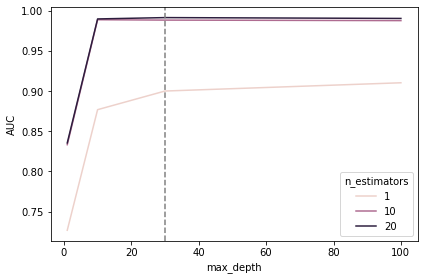

In [224]:
plot_param_search(clf, parameters)

In [199]:
plot_param_search_1d(clf, parameters)

For the model optimized by AUC:
	 the parameter is: {'max_depth': 100, 'n_estimators': 20}
	 the AUC is: 0.967764
	 the accuracy is: 0.990646
For the model optimized by Accuracy:
	 the parameter is: {'max_depth': 30, 'n_estimators': 20}
	 the AUC is: 0.968239
	 the accuracy is: 0.990362
Optimizing by AUC so best parameters are: {'alpha': 0.01}


ValueError: arrays must all be same length

In [190]:
def plot_param_search_1d(trained_model, parameters):

    # convert dictionary to lists for ease of use
    param_values = list(parameters.values())
    param_names = list(parameters.keys())
        
    # results
    cv_results = pd.DataFrame(trained_model.cv_results_)
    
    # print results of best classifier
    print('For the model optimized by AUC:')
    print('\t the parameter is: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'params'].to_string(index=False)))
    print('\t the AUC is: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'mean_test_Accuracy'].to_string(index=False)))
    print('\t the accuracy is: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'mean_test_AUC'].to_string(index=False)))

    print('For the model optimized by Accuracy:')
    print('\t the parameter is: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'params'].to_string(index=False)))
    print('\t the AUC is: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'mean_test_Accuracy'].to_string(index=False)))
    print('\t the accuracy is: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'mean_test_AUC'].to_string(index=False)))
    
    
    print("Optimizing by",refit_sc,"so best parameters are: {}".format(trn_clf.best_params_))
    
    # plot results
    
    acc_eval_scores = np.transpose(np.array(cv_results.mean_test_Accuracy))
    
    # xaxis
    scores_dict = {param_names[0]: parameters[param_names[0]]}   
    
    param_df = pd.DataFrame(scores_dict)
#     param_plot = pd.melt(param_df, id_vars=param_names[0], value_vars=param_values[1], var_name=param_names[1], value_name="AUC")

    sns.lineplot(parameters[param_names[0]], acc_eval_scores)
    
    plt.ylabel("AUC")
    plt.xlabel(param_names[0])
    plt.axvline(trained_model.best_params_[param_names[0]], 0,1, linestyle="dashed", color="grey")
    plt.tight_layout()
    # plt.savefig("model.png", dpi=600)
    plt.show()
    return None

In [88]:
model_names = ['kNN','Ridge','RandomForest','MLP','RBF SVM', 'linear SVM']
models = [KNeighborsClassifier(),
         RidgeClassifier(normalize=True),
         RandomForestClassifier(),
         SVC(kernel='linear')]
params = [{'n_neighbors':[int(np.sqrt(len(y_train))/16),
                       int(np.sqrt(len(y_train))/8),
                       int(np.sqrt(len(y_train))/4),
                       int(np.sqrt(len(y_train))/2),
                       int(np.sqrt(len(y_train))),
                       int(np.sqrt(len(y_train))*2),
                       int(np.sqrt(len(y_train))*4)],
            'weights': ['uniform', 'distance']}]



#     models.append(('RidgeReg', RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1],normalize=True)))
#     K_neighbors = int(np.sqrt(len(y_train)))
#     models.append(('KNN', KNeighborsClassifier(K_neighbors, weights='uniform')))
#     models.append(('NeuralNet', MLPClassifier(max_iter=200)))
#     models.append(('RandomForest', RandomForestClassifier()))
#     models.append(('RBF SVM', SVC(gamma=0.1, C=1, kernel='linear')))

In [74]:
model_names = ['linear SVM']
models = [SVC(kernel='linear')]
params = [{'C':[0.01,0.1,1,10]}]

In [80]:
plot_param_search_1d(trn_clf, parameters)

For the model optimized by AUC:
	 the parameter is: {'C': 0.01}
	 the AUC is: NaN
	 the accuracy is: NaN
For the model optimized by Accuracy:
	 the parameter is: {'C': 0.01}
	 the AUC is: NaN
	 the accuracy is: NaN
Optimizing by AUC so best parameters are: {'C': 0.01}


IndexError: list index out of range

In [86]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,...,std_test_AUC,rank_test_AUC,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy
0,9.907402,0.791382,0.003312,0.004030,0.01,{'C': 0.01},NaN,NaN,NaN,NaN,...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,5.678107,0.206064,0.001181,0.000060,0.1,{'C': 0.1},NaN,NaN,NaN,NaN,...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,4.824273,0.155127,0.001259,0.000187,1,{'C': 1},NaN,NaN,NaN,NaN,...,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,4.986516,0.079997,0.001140,0.000098,10,{'C': 10},NaN,NaN,NaN,NaN,...,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [84]:
trained_model = trn_clf

In [87]:
acc_eval_scores

array([nan, nan, nan, nan])

In [85]:

    # convert dictionary to lists for ease of use
    param_values = list(parameters.values())
    param_names = list(parameters.keys())
        
    # results
    cv_results = pd.DataFrame(trained_model.cv_results_)
    
    # print results of best classifier
    print('For the model optimized by AUC:')
    print('\t the parameter is: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'params'].to_string(index=False)))
    print('\t the AUC is: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'mean_test_Accuracy'].to_string(index=False)))
    print('\t the accuracy is: {}'.format(cv_results.loc[cv_results['rank_test_AUC']==1,'mean_test_AUC'].to_string(index=False)))

    print('For the model optimized by Accuracy:')
    print('\t the parameter is: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'params'].to_string(index=False)))
    print('\t the AUC is: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'mean_test_Accuracy'].to_string(index=False)))
    print('\t the accuracy is: {}'.format(cv_results.loc[cv_results['rank_test_Accuracy']==1,'mean_test_AUC'].to_string(index=False)))
    
    
    print("Optimizing by",refit_sc,"so best parameters are: {}".format(trn_clf.best_params_))
    
    # plot results
    
    acc_eval_scores = np.transpose(np.array(cv_results.mean_test_AUC))
    
    # xaxis
    scores_dict = {param_names[0]: parameters[param_names[0]]}
    # series
    for it, series_vals in enumerate(param_values[1]):
        scores_dict[series_vals] = acc_eval_scores[it,]
    
    
    param_df = pd.DataFrame(scores_dict)
    
    param_plot = pd.melt(param_df, id_vars=param_names[0], value_vars=param_values[1], var_name=param_names[1], value_name="AUC")

    sns.lineplot(x=param_names[0], y="AUC", data=param_plot)
    
    plt.axvline(trained_model.best_params_[param_names[0]], 0,1, linestyle="dashed", color="grey")
    plt.tight_layout()
    # plt.savefig("model.png", dpi=600)
    plt.show()

For the model optimized by AUC:
	 the parameter is: {'C': 0.01}
	 the AUC is: NaN
	 the accuracy is: NaN
For the model optimized by Accuracy:
	 the parameter is: {'C': 0.01}
	 the AUC is: NaN
	 the accuracy is: NaN
Optimizing by AUC so best parameters are: {'C': 0.01}


IndexError: list index out of range

In [94]:
model_names = ['Ridge']
models = [RidgeClassifier(normalize=True)]
params = [{'alpha':[0.01,0.1,1,10]}]

In [95]:
trained_models = []

for model, parameters, mod_name in zip(models,params, model_names):
    print("Started training model", mod_name)
    time_0 = time()
    trn_clf = train_opt_model(model, parameters, X_train, y_train, scoring, refit_sc)
    print("Finished training model in", round(time()-time_0,2),"seconds\n")

    if len(parameters) == 2:
        plot_param_search(trn_clf, parameters)   
    else:
        plot_param_search_1d(trn_clf, parameters)
        
    
    print("---------------------------\n")
    trained_models.append(trn_clf)

Started training model Ridge
Finished training model in 15.5 seconds

For the model optimized by AUC:
	 the parameter is: {'alpha': 0.01}
	 the AUC is: NaN
	 the accuracy is: NaN
For the model optimized by Accuracy:
	 the parameter is: {'alpha': 0.01}
	 the AUC is: NaN
	 the accuracy is: NaN
Optimizing by AUC so best parameters are: {'alpha': 0.01}


IndexError: list index out of range

In [46]:
compare_auc = []
compare_accuracy = []

for trn_model, mod_name in zip(trained_models, model_names):
    test_accuracy, test_auc_val = plot_roc_curve(trn_model, mod_name, X_test, y_test)
    compare_auc.append(test_auc_val)
    compare_accuracy.append(test_accuracy)

plt.show()

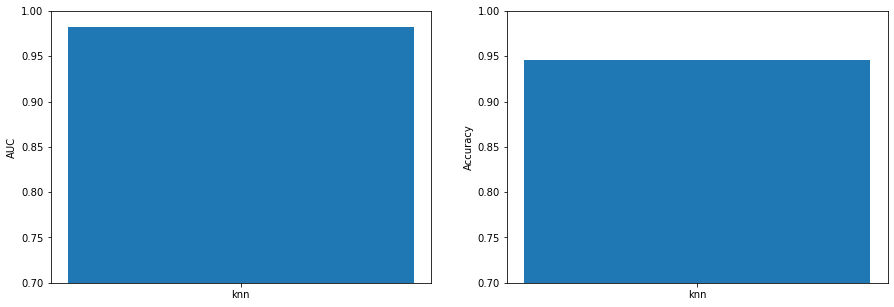

In [63]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].bar(model_names, compare_auc)
axs[1].bar(model_names, compare_accuracy)

axs[0].set_ylabel('AUC')
axs[1].set_ylabel('Accuracy')

axs[0].set_ylim(0.7,1.0)
axs[1].set_ylim(0.7,1.0)

plt.show()

# Functions

In [5]:
def data_to_unirep(df):
    """
    Generates a new data frame with the UniProt ID, UniRep 1900 vectors (x-values), and secretion state (y-values)
    
    Args:
        df (DataFrame): original data frame with sequence information and class information (specifying secretion)
        
    Returns:
        unirep_df (DataFrame): new unirep data frame with class information and unirep vectors
    """
    seq_key = 'Sequence'
    vec_prefix = 'Vec_{}'
    
    # Generating new data frame with unirep vectors
    vec_column_names = [vec_prefix.format(i) for i in range(1900)]        
    unirep_df = pd.DataFrame(columns = ['Class'] + vec_column_names)

    for i, row in df.iterrows():
        if int(i) % 1 == 0:
            print('row {}'.format(i), end='\r')
        sequence = row.loc[seq_key]
        unirep_df.loc[i, 'Class'] = row['Class']
        vec = get_UniReps(sequence)[0][0]
        unirep_df.loc[i, vec_column_names] = vec
    
    return unirep_df

In [32]:
def classifier_comparison(X, y, seed):
    """
    Iterates through sklearn supervised learning classification models.
    Performs k-fold cross-validation (k=10).
    Comparing each classifier based on model accuracy.
    Plots model accuracy on a boxplot.
    Taken from https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
    
    Args:
        X (Array-like): All of the input parameters (including UniRep vectors) for the secretion analysis model
        y (Array-like): The ouput parameter, or secretion class, for the secretion analysis model
        
    Returns:
        
    """
    # Preparing models
    models = []
    models.append(('RidgeReg', RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1],normalize=True)))
    K_neighbors = int(np.sqrt(len(y_train)))
    models.append(('KNN', KNeighborsClassifier(K_neighbors, weights='uniform')))
    models.append(('NeuralNet', MLPClassifier(max_iter=200)))
    models.append(('RandomForest', RandomForestClassifier()))
    models.append(('RBF SVM', SVC(gamma=0.1, C=1)))
    
    # Evaluating each model using cross-validation
    results = []
    names = []
    scoring = 'accuracy'
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, random_state=seed, shuffle=True)
        cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    # Plotting the classifier comparison
    fig = plt.figure()
    fig.suptitle('Sklearn Model Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

In [33]:
k_init_aprox = int(np.sqrt(len(y_train)))
parameters = {'n_neighbors':[int(k_init_aprox/8),
                       int(k_init_aprox/4),
                       int(k_init_aprox/2),
                       int(k_init_aprox),
                       int(k_init_aprox*2),
                       int(k_init_aprox*4),
                       int(k_init_aprox*8)],
             'weights': ['uniform', 'distance']}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [9, 19, 39, 79, 158, 316, 632],
                         'weights': ['uniform', 'distance']})

In [204]:
# Binarize the output
# y_labs = label_binarize(y_train, classes=['membrane', 'cytoplasm', 'secreted'])
# n_classes = y_labs.shape[1]

def plot_roc_curve(trained_classifier, model_name, X_test, y_test):
    
    # Binarize the output
    y_labs = label_binarize(y_test, classes=['cytoplasm', 'membrane','secreted'])
    n_classes = y_labs.shape[1]
    
    pred_probs = trained_classifier.best_estimator_.predict_proba(X_test)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_labs[:, i], pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
#     fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#     roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.plot(fpr["macro"], tpr["macro"],
             label=str(model_name)+', AUC: {:.3f}'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=1)

    
#     colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
#     for i, color in zip(range(n_classes), colors):
#         plt.plot(fpr[i], tpr[i], color=color, lw=2,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))


#     plt.plot([0, 1], [0, 1], 'k--', lw=lw)
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Some extension of Receiver operating characteristic to multi-class')
#     plt.legend(loc="lower right")
#     plt.show()

#     pred_probs = trained_classifier.best_estimator_.predict_proba(X_test)[:, 1]
#     test_auc = roc_auc_score(y_test, pred_probs)
#     labl = str(model_name)+', AUC: ' + '{:.3f}'.format(test_auc)
#     fpr, tpr, thresholds = roc_curve(y_test, pred_probs)
#     plt.plot(knn_fpr, knn_tpr, label=labl)

In [ ]:
def 

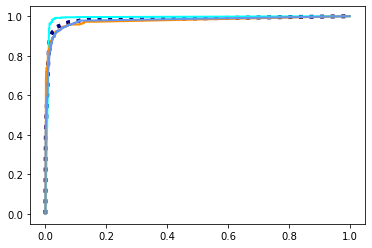

In [196]:
plot_roc_curve(trn_clf, 'knn', X_test, y_test)

In [ ]:
from sklearn.metrics import roc_auc_score
knn_probs = knn_cl.best_estimator_.predict_proba(X_test)[:, 1]
knn_auc   = roc_auc_score(y_test, knn_probs)
lr_probs  = lr_cl.best_estimator_.predict_proba(X_test)[:, 1]
lr_auc    = roc_auc_score(y_test, lr_probs)
svm_probs = svm_cl.best_estimator_.predict_proba(X_test)[:, 1]
svm_auc   = roc_auc_score(y_test, svm_probs)
rf_probs  = rf_cv.best_estimator_.predict_proba(X_test)[:, 1]
rf_auc    = roc_auc_score(y_test, rf_probs)
dt_probs  = dt_cv.best_estimator_.predict_proba(X_test)[:, 1]
dt_auc    = roc_auc_score(y_test, dt_probs)

In [ ]:
knn_auc_labl = 'kNN, AUC: ' + '{:.3f}'.format(knn_auc)
lr_auc_labl  = 'LR, AUC: ' + '{:.3f}'.format(lr_auc)
svm_auc_labl = 'SVM, AUC: ' + '{:.3f}'.format(svm_auc)
rf_auc_labl  = 'RF, AUC: ' + '{:.3f}'.format(rf_auc)
dt_auc_labl  = 'DT, AUC: ' + '{:.3f}'.format(dt_auc)

In [ ]:
from sklearn.metrics import roc_curve
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn_cl.best_estimator_.predict_proba(X_test)[:, 1])
plt.plot(knn_fpr, knn_tpr, label=knn_auc_labl)
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, lr_cl.best_estimator_.predict_proba(X_test)[:, 1])
plt.plot(lr_fpr, lr_tpr, label=lr_auc_labl)
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test, svm_cl.best_estimator_.decision_function(X_test))
plt.plot(svm_fpr, svm_tpr, label=svm_auc_labl)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_cv.best_estimator_.predict_proba(X_test)[:, 1])
plt.plot(rf_fpr, rf_tpr, label=rf_auc_labl)
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, dt_cv.best_estimator_.predict_proba(X_test)[:, 1])
plt.plot(dt_fpr, dt_tpr, label=dt_auc_labl)

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
knn_close_zero = np.argmin(np.abs(knn_thresholds - 0.5))
plt.plot(knn_fpr[knn_close_zero], knn_tpr[knn_close_zero], 'o', markersize=8, fillstyle="none", c='k', mew=1)
lr_close_zero = np.argmin(np.abs(lr_thresholds - 0.5))
plt.plot(lr_fpr[lr_close_zero], lr_tpr[lr_close_zero], 'o', markersize=8, fillstyle="none", c='k', mew=1)
svm_close_zero = np.argmin(np.abs(svm_thresholds - 0.5))
plt.plot(svm_fpr[svm_close_zero], svm_tpr[svm_close_zero], 'o', markersize=8, fillstyle="none", c='k', mew=1)
rf_close_zero = np.argmin(np.abs(rf_thresholds - 0.5))
plt.plot(rf_fpr[rf_close_zero], rf_tpr[rf_close_zero], 'o', markersize=8, fillstyle="none", c='k', mew=1)
dt_close_zero = np.argmin(np.abs(dt_thresholds - 0.5))
plt.plot(dt_fpr[dt_close_zero], dt_tpr[dt_close_zero], 'o', markersize=8, fillstyle="none", c='k', mew=1)
plt.legend(loc=4)
plt.tight_layout()
plt.savefig("ROC curve.png", dpi=600)
plt.show()

In [7]:
# Selecting the final models to build
def ridge_regression_classifier(X_train, y_train):
    """
    Performs ridge regression classification on the given X and y values. Trains the model using X_train and y_train.
    
    Args:
        X_train (Array-like): input parameters (including UniRep vectors) for the training the secretion analysis model
        y_train (Array-like): secretion class / output associated with the trained secretion data (X_train)
    
    Returns:
        model: ridge regression classification model
    """
    parameters = {'alphas':[1e-3, 1e-2, 1e-1, 1]}
    ridge = RidgeClassifierCV(normalize=True)
    clf = GridSearchCV(ridge, parameters)
    clf.fit(X_train, y_train)
    return clf


def knn_classifier(X_train, X_test, y_train, y_test):
    """
    Performs K-nearest neighbors classification on the given X and y values. Trains the model using X_train and y_train.
    
    Args:
        X_train (Array-like): input parameters (including UniRep vectors) for the training the secretion analysis model
        X_test (Array-like): input parameters (including UniRep vectors) for testing the secretion model
        y_train (Array-like): secretion class / output associated with the trained secretion data (X_train)
        y_test (Array-like): secretion class / output associated with the tested secretion data (X_test)
    
    Returns:
        model: K-nearest neighbors classification model
    """
    k_init_aprox = int(np.sqrt(len(y_train)))
    parameters = {'k':[int(k_init_aprox/8),
                       int(k_init_aprox/4),
                       int(k_init_aprox/2),
                       int(k_init_aprox),
                       int(k_init_aprox*2),
                       int(k_init_aprox*4),
                       int(k_init_aprox*8)]}
    knn = KNeighborsClassifier(weights='uniform')
    clf = GridSearchCV(knn, parameters)
    clf.fit(X_train, y_train)
    return clf

    K_neighbors = int(np.sqrt(len(y_train))) # set number of neighbors to square root of number of inputs
    model = KNeighborsClassifier(K_neighbors, weights='uniform', cv=5, scoring="accuracy", n_jobs=-1)
    model.fit(X_train, y_train)
    return model


def neural_net_classifier(X_train, X_test, y_train, y_test):
    """
    Performs MLP classification on the given X and y values. Trains the model using X_train and y_train.
    
    Args:
        X_train (Array-like): input parameters (including UniRep vectors) for the training the secretion analysis model
        X_test (Array-like): input parameters (including UniRep vectors) for testing the secretion model
        y_train (Array-like): secretion class / output associated with the trained secretion data (X_train)
        y_test (Array-like): secretion class / output associated with the tested secretion data (X_test)
    
    Returns:
        model: MLP classification model (sklearn neural network)
    """
    model = MLPClassifier(max_iter=200)
    model.fit(X_train, y_train)
    return model


def random_forest_classifier(X_train, X_test, y_train, y_test):
    """
    Uses random forests to classify based on the given X and y values.
    
    Args:
        X_train (Array-like): input parameters (including UniRep vectors) for the training the secretion analysis model
        X_test (Array-like): input parameters (including UniRep vectors) for testing the secretion model
        y_train (Array-like): secretion class / output associated with the trained secretion data (X_train)
        y_test (Array-like): secretion class / output associated with the tested secretion data (X_test)
    
    Returns:
        model: random forest classification model
    """
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    return model


def rbf_svm_classifier(X_train, X_test, y_train, y_test):
    """
    Uses rbf support vector machines to classify based on the given X and y values.
    
    Args:
        X_train (Array-like): input parameters (including UniRep vectors) for the training the secretion analysis model
        X_test (Array-like): input parameters (including UniRep vectors) for testing the secretion model
        y_train (Array-like): secretion class / output associated with the trained secretion data (X_train)
        y_test (Array-like): secretion class / output associated with the tested secretion data (X_test)
    
    Returns:
        model: rbf svm classficiation model
    """
# Run the following in order to figure out the best C and gamma values!
#     C_range = np.logspace(-2, 10, 13)
#     gamma_range = np.logspace(-3, 3, 7)
#     for i in range(len(C_range)):
#     for j in range(len(gamma_range)):
#         model=SVC(gamma=gamma_range[j], C=C_range[i]).fit(X_train, y_train)
#         print("Gamma:", gamma_range[j], "C:", C_range[i], "Score:", model.score(X_test, y_test))
    model = SVC(gamma=0.1, C=1)
    model.fit(X_train, y_train)
    return model

In [8]:
# These parameters are for the `use_additional_features` function
# They are from the Hessa et al. paper cited in the function
params = pd.read_csv('Params.csv', header=None)
lst = params[0].values
params.set_index(lst, inplace=True)
del params[0]
params_dict = defaultdict(list)
for i, row in params.iterrows():
    for position in range(1, len(row) + 1):
        params_dict[i].append(float(row.loc[position]))

In [9]:
def use_additional_features(df):
    """
    Uses additional features to help improve the model. 
    Additional features include:
        theoretical isoelectric point, amino acid length, amino acid weight,
        free energy of transmembrane insertion
        
    Check https://biopython.org/docs/1.75/api/Bio.SeqUtils.html
    Free energy of transmembrane insertion values from
        Hessa, T., Meindl-Beinker, N., Bernsel, A. et al. Molecular code for transmembrane-helix recognition 
        by the Sec61 translocon. Nature 450, 1026–1030 (2007). https://doi.org/10.1038/nature06387
    
    Args:
        df (DataFrame): data frame including all of the inputs (sequence, unirep vectors, and secretion class)
    
    Returns:
        df_with_add_features (DataFrame): modified data frame with additional features listed above
    """
    # First append new columns for the theoretical isoelectric point,
    # amino acid length, and molecular weight
    seq_key = 'seq'
    df_with_add_features = df.copy(deep=True)
    df_with_add_features['PI'] = 0
    df_with_add_features['Molecular_Weight'] = 0
    df_with_add_features['Sequence_Length'] = 0
    for i, row in df_with_add_features.iterrows():
        seq = row.loc[seq_key]
        seq_obj = IP(seq)
        df_with_add_features.loc[i, 'PI'] = seq_obj.pi()
        df_with_add_features.loc[i, 'Molecular_Weight'] = round(molecular_weight(seq, seq_type='protein'))
        df_with_add_features.loc[i, 'Sequence_Length'] = len(seq)

    # Next, add the free energy of membrane insertion values
    df_with_add_features['dG'] = 0
    for i, row in df.iterrows():
        if int(i) % 10 == 0:
            print('row {} of {}'.format(i, len(df.index)), end="\r") # Set a progress check
        seq = row.loc[seq_key]
        # Skips sequence if the entire sequence length is less than 19
        if len(seq) < 19:
            continue
        dg_values = []
        # Scans sequence for every 19-residue frame
        for j in range(len(seq)-18):
            running_total = 0
            new_segment = seq[j:j+19]
            for k, aa in enumerate(new_segment):
                if aa == 'U':
                    pass
                else:
                    running_total += params_dict[aa][k]
            dg_values.append(running_total) 
        # Finds the minimum dG value
        df_with_add_features.loc[i, 'dG'] = min(dg_values)
        
    # Finally, return the updated data frame with additional features
    return df_with_add_features

In [10]:
def secretion_optimization_unirep(seq, pos, model):
    """
    Based on the given model, this function mutates the input sequence at the position provided
    Uses only the unirep vectors as input values
    
    Args:
        seq (String): initial amino acid sequence provided with single-letter format
        pos (int): position where the mutations can occur in the given sequence
        model:
    
    Returns:
        seq (String): final, mutated amino acid sequence with improved secretion score
    """
    # First, obtain the unirep representation of given sequence
    unirep_values = get_UniReps(seq)[0]
    unirep_values = unirep_values.reshape(1, -1)
    
    # Next, predict the initial secretion score
    print("The initial sequence is:", seq)
    initial_class = model.predict(unirep_values)
    print("The initial class is:", initial_class)
    classes = list(model.classes_)
    if type(model) is RidgeClassifierCV:
        decision_function_values = model.decision_function(unirep_values)[0]
        probs = np.exp(decision_function_values) / np.sum(np.exp(decision_function_values))
        initial_score = probs[classes.index('secreted')]
    else:
        prediction_probability = list(model.predict_proba(unirep_values)[0]) # Grabbing the probability of each class
        initial_score = prediction_probability[classes.index('secreted')] # Grabbing the probability of being secreted class
    print("The initial probability of being the secreted class is:", initial_score)
    
    # Set up list of amino acids
    amino_acids = ['G', 'A', 'L', 'M', 'F', 'W', 'K', 'Q', 'E', 'S', 'P', 'V', 'I', 'C', 'Y', 'H', 'R', 'N', 'D', 'T']
    
    # Set up point mutations
    mutated_scores_for_all_AA = []
    for i in range(len(amino_acids)):
        seq_list = list(seq)
        seq_list[pos] = amino_acids[i]
        new_seq = "".join(seq_list) # Creating the point-mutated sequence
        mutated_unirep_values = get_UniReps(new_seq)[0] # Grabbing the input parameters (unirep vectors)
        mutated_unirep_values = mutated_unirep_values.reshape(1, -1)
        mutated_class = model.predict(mutated_unirep_values) # The class of the mutated sequence
        classes = list(model.classes_)
        if type(model) is RidgeClassifierCV:
            decision_function_values = model.decision_function(mutated_unirep_values)[0]
            probs = np.exp(decision_function_values) / np.sum(np.exp(decision_function_values))
            mutated_score = probs[classes.index('secreted')]
        else:
            prediction_probability = list(model.predict_proba(mutated_unirep_values)[0]) # Grabbing the probability of each class
            mutated_score = prediction_probability[classes.index('secreted')] # Grabbing the probability of being secreted class
        mutated_scores_for_all_AA.append(mutated_score)
        if mutated_score > initial_score:
            seq = new_seq
            initial_score = mutated_score
            initial_class = mutated_class
    print("The improved, mutated sequence is:", seq)
    print("The mutated class is:", initial_class)
    print("The mutated probability of being the secreted class is:", initial_score)
    
    plt.plot(amino_acids, mutated_scores_for_all_AA)
    plt.xlabel('Amino Acid Point Mutation')
    plt.ylabel('Probability of Class: Secreted (%)')
    plt.show()
            
    return seq

# Refined Code and Analysis for Updated UniRep Datasets

First, run the sklearn model comparison function for the human data set with and without the signal peptide.

In [10]:
# Running the model comparison on human data set WITH signal peptides
X = np.stack(human_unirep_withSP["UniRep"].to_numpy())
y = np.array(human_unirep_withSP['location'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
classifier_comparison(X, y, 42)

RidgeReg: 0.972815 (0.003944)
KNN: 0.906504 (0.007450)



KeyboardInterrupt



In [ ]:
# Running the model comparison on human data set WITHOUT signal peptides
X2 = np.stack(human_unirep_noSP["UniRep"].to_numpy())
y2 = np.array(human_unirep_noSP['location'])
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [ ]:
classifier_comparison(X2, y2, 42)

Next, test the secretion optimizer mutation function.

In [ ]:
# Using an example model to test out the secretion_optimization_unirep function
# Using human data WITHOUT signal peptides
model = ridge_regression_classifier(X2_train, X2_test, y2_train, y2_test) # Define function used
seq = 'ACCAMGGSGCGSGSGSACCAMGGS' # Provide initial sequence
position = 10 # Provide position for point mutations

secretion_optimization_unirep(seq, position, model)

Now, move on to analysis including additional features.

In [ ]:
# Appending additional features to the human data
# First, omit sequences with ambiguous 'X' or 'B'
new_human_unirep_noSP = human_unirep_noSP[~human_unirep_noSP['seq'].str.contains("X") &
                                         ~human_unirep_noSP['seq'].str.contains("B")]
new_human_unirep_withSP = human_unirep_withSP[~human_unirep_withSP['seq'].str.contains("X") &
                                             ~human_unirep_noSP['seq'].str.contains("B")]

human_unirep_withSP_add = use_additional_features(new_human_unirep_withSP)
human_unirep_noSP_add = use_additional_features(new_human_unirep_noSP)
human_unirep_noSP_add.head()

In [ ]:
# Perform a rough comparison with initial models
# Analysis below WITHOUT signal peptides
X3 = np.stack(human_unirep_noSP_add["UniRep"].to_numpy())
y3 = np.array(human_unirep_noSP_add['location'])
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

ridge1 = ridge_regression_classifier(X2_train, X2_test, y2_train, y2_test)
ridge2 = ridge_regression_classifier(X3_train, X3_test, y3_train, y3_test)

print("Initial:", ridge1.score(X2_test, y2_test), "With additional features:", ridge2.score(X3_test, y3_test))

In [ ]:
classifier_comparison(X3, y3, 42)